<a href="https://colab.research.google.com/github/pedroescobedob/DS-Unit-2-Kaggle-Challenge/blob/master/Pedro_Escobedo_assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [37]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [39]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [40]:
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


# Train / Validate / Test

In [41]:
# Separate train into train and validate test has a different csv
train, val = train_test_split(train, train_size = 0.80, test_size = 0.20,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

# Function to wrangle train, validate, and test

In [0]:
import numpy as np

def cleaning_data(X):
  # Create a copy before modifying
  X = X.copy()

  # Removing duplicates and missing values columns
  X = X.drop(columns=['num_private', 'extraction_type_group', 'extraction_type_class', 
                      'payment', 'quality_group', 'quantity_group',
                      'source_type', 'waterpoint_type_group'])
  
  # Latitude has small values near zero, we'll treat these values like zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # Replace the zeros with nulls
  cols_with_zeros = ['longitude', 'latitude', 'population', 'construction_year']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  # Extract year from date_recorded
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  X['date_recorded'] = X['date_recorded'].dt.year

  # Time until pump was inspected
  X['pump_i'] = X['date_recorded'] - X['construction_year']

  return X

In [0]:
train = cleaning_data(train)
val = cleaning_data(val)
test = cleaning_data(test)

In [44]:
pd.isnull(cleaning_data)

False

In [45]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group,pump_i
43360,72938,0.0,2011,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,NaN,True,GeoData Consultants Ltd,VWC,K,NaN,NaN,gravity,vwc,user-group,never pay,soft,insufficient,spring,groundwater,communal standpipe,functional,NaN
7263,65358,500.0,2011,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175.0,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008.0,gravity,wua,user-group,monthly,soft,enough,spring,groundwater,communal standpipe,functional,3.0
2486,469,25.0,2011,Donor,290,Do,38.238568,-6.179919,Kwasungwini,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300.0,True,GeoData Consultants Ltd,VWC,NaN,False,2010.0,india mark ii,vwc,user-group,per bucket,salty,insufficient,shallow well,groundwater,hand pump,functional,1.0
313,1298,0.0,2011,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,NaN,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,other,vwc,user-group,never pay,soft,enough,shallow well,groundwater,other,non functional,NaN
52726,27001,0.0,2011,Water,0,Gove,35.389331,-6.399942,Chama,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,NaN,True,GeoData Consultants Ltd,VWC,Zeje,True,NaN,mono,vwc,user-group,per bucket,soft,enough,machine dbh,groundwater,communal standpipe,functional,NaN


In [46]:
train.describe(exclude='number')

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group
count,44616,44603,47520,47520,47234,47520,47520,47520,44876,47520,44392,24988,45077,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520
unique,1716,1929,30661,9,17231,21,124,2082,2,1,12,2563,2,18,12,5,7,8,5,10,3,7,3
top,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,vwc,user-group,never pay,soft,enough,spring,groundwater,communal standpipe,functional
freq,7321,13978,2879,8137,420,4250,2003,257,40838,47520,29470,548,31071,21448,32449,42027,20287,40598,26567,13620,36638,22778,25807


In [47]:
# Look at the methods used to extract water
print(train['waterpoint_type'].unique())
train['extraction_type'].value_counts()

['communal standpipe' 'hand pump' 'other' 'communal standpipe multiple'
 'improved spring' 'cattle trough' 'dam']


gravity                      21448
nira/tanira                   6526
other                         5193
submersible                   3770
swn 80                        2930
mono                          2261
india mark ii                 1928
afridev                       1435
ksb                           1124
other - rope pump              353
other - swn 81                 184
windmill                        93
india mark iii                  73
cemo                            70
other - play pump               65
walimi                          42
climax                          24
other - mkulima/shinyanga        1
Name: extraction_type, dtype: int64

In [48]:
# Quantity of water
print(train['quantity'].unique())
train['quantity'].describe()

['insufficient' 'enough' 'dry' 'seasonal' 'unknown']


count      47520
unique         5
top       enough
freq       26567
Name: quantity, dtype: object

In [49]:
# Look at the methods of payment
print(train['payment_type'].unique())
train[['payment_type']].describe()

['never pay' 'monthly' 'per bucket' 'unknown' 'annually' 'on failure'
 'other']


,payment_type
count,47520
unique,7
top,never pay
freq,20287


# Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.


In [51]:
target = 'status_group'

# Features
features = train.drop(columns=[target, 'id'])

# Features with only numbers
numeric_features = features.select_dtypes(include='number').columns.tolist()

# Series with the cardinality of the nonnumeric features
cardinality = features.select_dtypes(exclude='number').nunique()
# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# All features
all_features = numeric_features + categorical_features
print(all_features)

['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'pump_i', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'management', 'management_group', 'payment_type', 'water_quality', 'quantity', 'source', 'source_class', 'waterpoint_type']


In [0]:
# Arrange data into X features matrix and y target vector
X_train = train[all_features]
y_train = train[target]
X_val = val[all_features]
y_val = val[target]
X_test = test[all_features]

# Validation accuracy score

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [57]:
# Use pipeline
pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(),
      StandardScaler(),
      DecisionTreeClassifier(min_samples_leaf=25, random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on val
print('Decision Tree:')
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Decision Tree:
Train Accuracy 0.7994949494949495
Validation Accuracy 0.7644781144781144


# Get and plot feature importances



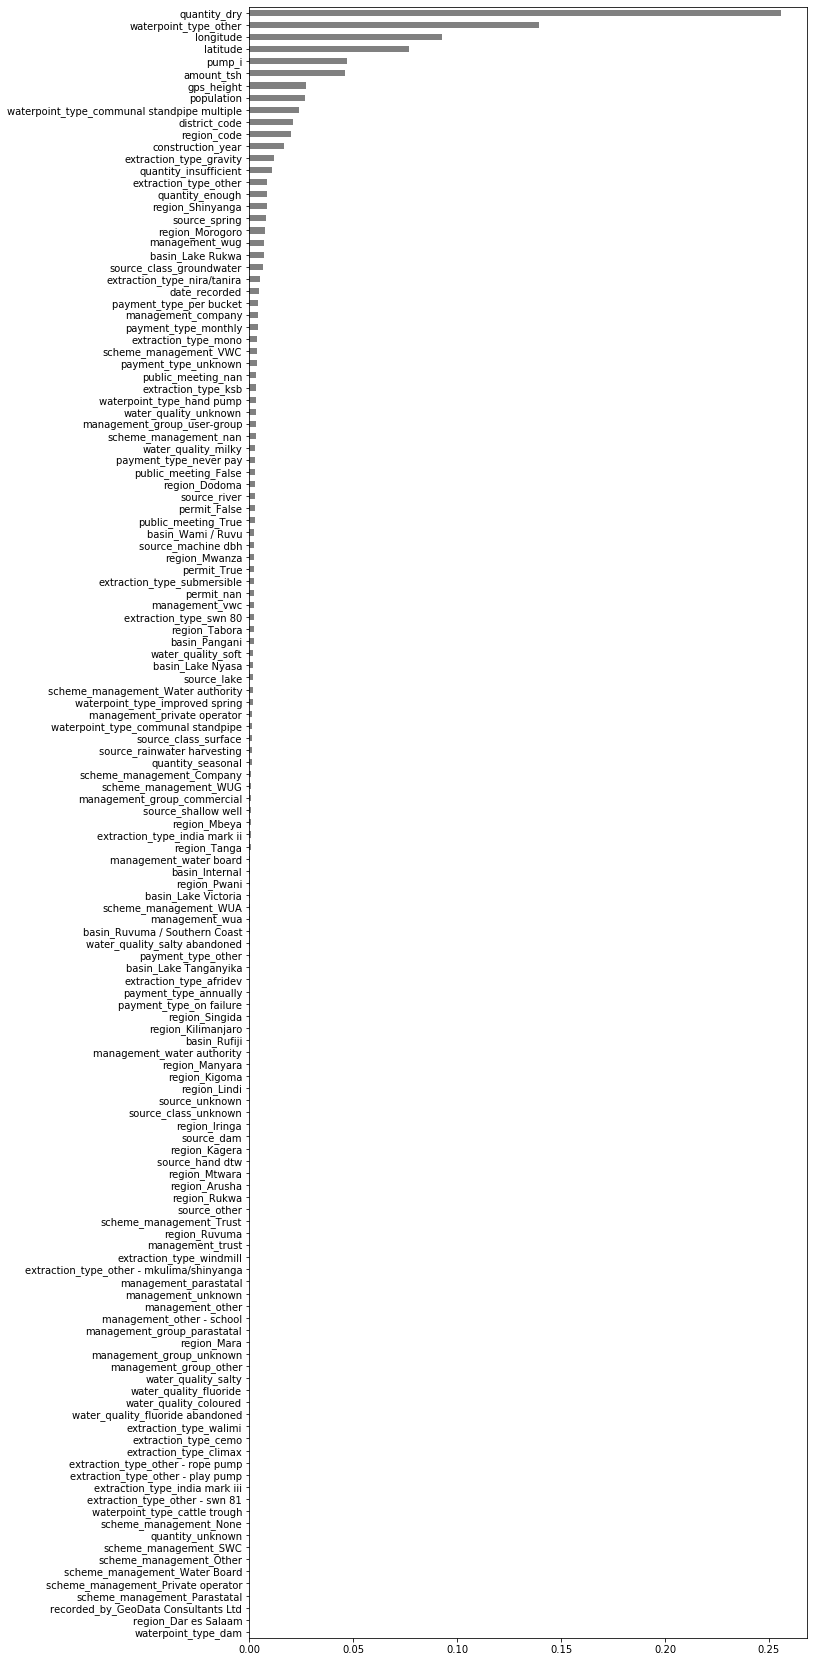

In [58]:
import matplotlib.pyplot as plt

# Model to Decision Trees
model = pipeline.named_steps['decisiontreeclassifier']

encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');